# Model Evaluation

Contents:
1. Overfitting vs Underfitting
2. Validation and Learning Curves
3. Bias vs Variance
4. Baseline Comparison
5. Cross Validation
    1. Intro
    2. Strategies
        1. Stratification
        2. Sample Grouping
        3. Non IID Data
    3. Nested
    4. Hyperparameters
6. Classification Metrics
7. Regression Metrics

## Overfitting vs Underfitting

<img src="diagrams/OverfitVUnderfit.jpg" width=600/>

If a model __underfits__ (left), it does not capture enough information from the training set to model the relationship accurately. 

If a model __overfits__ (right), it captures too much information from the training set, and models the training set very accurately but will fail to accurately model new data, as it may have taken in too much of the __noise__.


<img src="diagrams/OverfitVUnderfitNewData.jpg" width=600/>

<table>
    <tr>
        <td> <img src="diagrams/Underfit.jpg" width=700/></td> 
        <td> <img src="diagrams/Overfit.jpg" width=700/></td>
    </tr>
</table>

## Validation and Learning Curves

### (i) Validation Curves

A validation curve looks at how the train and test errors vary as an aspect of the model is changed.

<img src="diagrams/Validation%20Curve.jpg" width=600/>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target
target *= 100  # rescale the target in k$

In [3]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()

In [4]:
from sklearn.model_selection import cross_validate, ShuffleSplit

cv = ShuffleSplit(n_splits=30, test_size=0.2)

In [5]:
%%time
from sklearn.model_selection import validation_curve

# list of depths to try
max_depth = [1, 5, 10, 15, 20, 25]

# return results using validation_curve() function
train_scores, test_scores = validation_curve(
    regressor, data, target, param_name="max_depth", param_range=max_depth,
    cv=cv, scoring="neg_mean_absolute_error", n_jobs=2)
# get errors from score
train_errors, test_errors = -train_scores, -test_scores

Wall time: 36.6 s


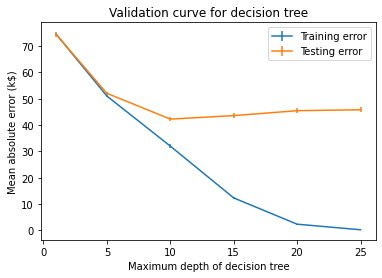

In [6]:
# plot training errors
plt.errorbar(max_depth, train_errors.mean(axis=1),
             # yerr is the std at each point
             yerr=train_errors.std(axis=1), label='Training error')
# plot training errors
plt.errorbar(max_depth, test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1), label='Testing error')
plt.legend()

plt.xlabel("Maximum depth of decision tree")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Validation curve for decision tree")

The validation curve can be divided into three areas:

- For `max_depth < 10`, the decision tree underfits. The training error and therefore the testing error are both high. The model is too constrained and cannot capture much of the variability of the target variable.

- At `max_depth = 10` we have the parameter for which the decision tree generalizes the best. It is flexible enough to capture a fraction of the variability of the target that generalizes, while not memorizing all of the noise in the target.

- For `max_depth > 10`, the decision tree overfits. The training error becomes very small, while the testing error increases. In this region, the models create decisions specifically for noisy samples harming its ability to generalize to test data.

Note that for `max_depth = 10`, the model __overfits a bit__ as there is a gap between the training error and the testing error. It can also potentially __underfit__ also a bit at the same time, because the __training error is still far from zero__ (more than 30 k$), meaning that the model might still be too constrained to model interesting parts of the data. However, the testing error is minimal, and this is what really matters. This is the best compromise we could reach by just tuning this parameter.

Be aware that looking at the __mean__ errors is quite limiting. We also included the __standard deviation__ to assess the dispersion of the score. In this case the variance of the errors is small compared to the respective error values, so the conclusion is quite clear

### (ii) Learning Curves

Similar to a validation curve, a __learning curve__ compares the train and test errors as the sizes of the train and test sets vary.

<table>
    <tr>
        <td> <img src="diagrams/LearningCurve1.jpg" /></td> 
        <td> <img src="diagrams/LearningCurve2.jpg" /></td>
        <td> <img src="diagrams/LearningCurve3.jpg" /></td>
    </tr>
</table>

In [7]:
# vary the size of the training set from 10% to 100%
train_sizes = np.linspace(0.1, 1.0, num=5, endpoint=True)
train_sizes

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

In [8]:
cv = ShuffleSplit(n_splits=30, test_size=0.2)

In [9]:
from sklearn.model_selection import learning_curve

results = learning_curve(
    regressor, data, target, train_sizes=train_sizes, cv=cv,
    scoring="neg_mean_absolute_error", n_jobs=2)

train_size, train_scores, test_scores = results#[:3]
# Convert the scores into errors
train_errors, test_errors = -train_scores, -test_scores

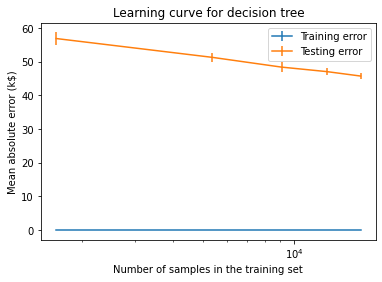

In [10]:
plt.errorbar(train_size, train_errors.mean(axis=1),
             yerr=train_errors.std(axis=1), label="Training error")
plt.errorbar(train_size, test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1), label="Testing error")
plt.legend()

plt.xscale("log")
plt.xlabel("Number of samples in the training set")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Learning curve for decision tree")

Looking at the training error alone, we see that we get an error of 0 k$. It means that the trained model (i.e. decision tree) is clearly __overfitting the training data__.

Looking at the testing error alone, we observe that the more samples are added into the training set, the lower the testing error becomes. Also, we are searching for the __plateau of the testing error__ for which there is no benefit to adding samples anymore or assessing the potential gain of adding more samples into the training set.

If we achieve a plateau and adding new samples in the training set does not reduce the testing error, we might have reach the __Bayes error rate__ using the available model. Using a more complex model might be the only possibility to reduce the testing error further.

## Bias vs Variance

<table>
    <tr>
        <td> <img src="diagrams/UnderfitBias.jpg" width=700/></td> 
        <td> <img src="diagrams/OverfitVariance.jpg" width=700/></td>
    </tr>
</table>

Machine learning operates with finite training set:

What if we used a different training set?

- How different would the resulting learned prediction functions be?

- What would be their average test error?

The __overfitting__ problem is one of __variance__: on __average__, the predictions are not necessarily off, but __each tend to fall far from the target__. This can be seen by their large spread around the best possible prediction.

For our machine learning example, this situation corresponds to a high complexity model class that is affected by how the noise in the data generating process makes the observations vary from one small training set to another.

Now consider an __underfitting model__: polynomial of degree 1 (which is just a linear prediction function).

Since the true generative process is non-linear, our fitted prediction function is bound to make prediction errors for some regions of the input space. Upon resampling the training set, one can see that the resulting training function stays very similar: the slope moves a bit.
Even more importantly, for a __given region of the input space__, the __underfitting models tend to make similar kinds of prediction errors__.

__Underfitting__ leads to __systematic biases__: the predictions cannot be on target on average, because the model that we used to predict is systematically off the data-generating process.

This __bias-variance tradeoff__ is classic in statistics. Often, adding a little bit of bias helps reducing the variance. For instance, as with throwing darts at a target, throwing the darts less strong might lead to being below the target on average, but with less scatter.

In summary:

__High bias == underfitting:__

- systematic prediction errors
- the model prefers to ignore some aspects of the data
- mispecified models

__High variance == overfitting:__

- prediction errors without obvious structure
- small change in the training set, large change in model
- unstable models

The bias can come from the choice of the model family.

## Baseline Comparison

When evaluating a models performance it is good to have a baseline to compare it to. In this example we will use a DummyRegressor, which simply predicts the average/mean target value, and does __not use any information from the input features__.

In [11]:
data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$

cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=0)

In [12]:
# create model to evaulate
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate

regressor = DecisionTreeRegressor()
cv_results_tree_regressor = cross_validate(
    regressor, data, target, cv=cv, scoring="neg_mean_absolute_error", n_jobs=2
)

errors_tree_regressor = pd.Series(
    -cv_results_tree_regressor["test_score"], name="Decision tree regressor"
)
errors_tree_regressor.describe()

count    30.000000
mean     45.699067
std       1.205518
min      43.146673
25%      44.833246
50%      45.586638
75%      46.697376
max      47.996411
Name: Decision tree regressor, dtype: float64

In [13]:
# create baseline for comparison
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy="mean")
result_dummy = cross_validate(
    dummy, data, target, cv=cv, scoring="neg_mean_absolute_error", n_jobs=2
)
errors_dummy_regressor = pd.Series(
    -result_dummy["test_score"], name="Dummy regressor"
)
errors_dummy_regressor.describe()

count    30.000000
mean     91.140009
std       0.821140
min      89.757566
25%      90.543652
50%      91.034555
75%      91.979007
max      92.477244
Name: Dummy regressor, dtype: float64

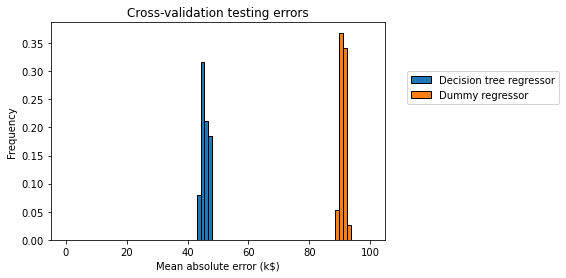

In [14]:
# combine results
all_errors = pd.concat(
    [errors_tree_regressor, errors_dummy_regressor],
    axis=1,
)
# plot errors
bins = np.linspace(start=0, stop=100, num=80)
all_errors.plot.hist(bins=bins, density=True, edgecolor="black")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Cross-validation testing errors")

We see that the generalization performance of our decision tree is far from being perfect: the price predictions are off by more than 45,000 US dollars on average. However it is much better than the mean price baseline. So this confirms that it is possible to predict the housing price much better by using a model that takes into account the values of the input features (housing location, size, neighborhood income…). Such a model makes more informed predictions and approximately divide the error rate by a factor of 2 compared to the baseline that ignores the input features.

Here we used the __mean__ price as the baseline prediction. We could have used the __median__ instead. For this particular example, using the mean instead of the median does not make much of a difference but this could have been the case for dataset with __extreme outliers__.

# Cross Validation

## Introduction 

In machine learning, when training a model we split the original data into a __training set__ and a __testing set__. The score of a model will in general __depend on the way we make such a split__.

One downside of doing a __single split__ is that it does not give any information about this __variability__ or the __robustness__ of the evaluation of our predictive model. Another downside, in a setting where the amount of data is small, is that the data available for training and testing will be even smaller after splitting.

Instead, we can use __cross-validation__. Cross-validation consists of __repeating the procedure__ such that the training and testing sets are __different each time__. Generalization performance metrics are collected for each repetition and then __aggregated__. As a result we can assess the variability of our measure of the model’s generalization performance.

Cross-validation is therefore __computationally intensive__ because it requires __training several models__ instead of __one__.

In [15]:
data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$

### (i) KFold

This strategy of cross-validation splits the entire dataset into `k` partitions. The `fit/score` procedure is repeated `K` times where at each iteration `K - 1` partitions are used to fit the model and 1 partition is used to score.

<img src="diagrams/KFold.jpg" width=600/>

In [16]:
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(data, target)

DecisionTreeRegressor(random_state=0)

In [17]:
%%time

cv_result = cross_validate(regressor, data, target, cv=5)
cv_result

Wall time: 3 s


{'fit_time': array([0.52488732, 0.7066288 , 0.46089029, 0.7485559 , 0.41636705]),
 'score_time': array([0.01023602, 0.01435542, 0.00600076, 0.00631452, 0.00361395]),
 'test_score': array([0.26291527, 0.41947109, 0.44492564, 0.23357874, 0.40788361])}

The output of `cross_validate` is a Python dictionary, which by default contains three entries:

(i) the time to train the model on the training data for each fold,

(ii) the time to predict with the model on the testing data for each fold,

(iii) the default score on the testing data for each fold.

Setting `cv=5` created 5 distinct splits to get 5 variations for the training and testing sets. Each training set is used to fit one model which is then scored on the matching test set. The default strategy when setting `cv=int` is the `K-fold cross-validation` where K corresponds to the (integer) number of splits. Setting cv=5 or cv=10 is a common practice, as it is a good trade-off between computation time and stability of the estimated variability.

Note that by __default__ the `cross_validate` function __discards the K models__ that were trained on the different overlapping subset of the dataset. The goal of cross-validation is not to train a model, but rather to estimate approximately the generalization performance of a model that would have been trained to the full training set, along with an estimate of the variability (uncertainty on the generalization accuracy).

You can pass additional parameters to `sklearn.model_selection.cross_validate` to collect additional information, such as the training scores of the models obtained on each round or even return the models themselves instead of discarding them. 

In [18]:
scores = cv_result["test_score"]
print(
    "The mean cross-validation accuracy is: "
    f"{scores.mean():.3f} +/- {scores.std():.3f}"
)

The mean cross-validation accuracy is: 0.354 +/- 0.087


### (ii) Shuffle-Split

At each iteration of this strategy we:

- randomly shuffle the order of the samples of a copy of the full dataset;

- split the shuffled dataset into a train and a test set;

- train a new model on the train set;

- evaluate the testing error on the test set.

We repeat this procedure `n_splits` times. Keep in mind that the computational cost increases with `n_splits`. The diagram below represents a shuffle-split using `n_splits=5`.

<img src="diagrams/ShuffleSplit.jpg" width=600/>

In [19]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=40, test_size=0.3, random_state=0)

# using the same model and data as before
cv_results = cross_validate(
    regressor, data, target, cv=cv, scoring="neg_mean_absolute_error")

In [20]:
cv_results = pd.DataFrame(cv_results)
cv_results.head()

,fit_time,score_time,test_score
0,0.225225,0.008710,-46.909797
1,0.386772,0.012085,-46.421170
2,0.479654,0.011110,-47.411089
3,0.389925,0.008282,-44.319824
4,0.370736,0.012806,-47.607875


In [21]:
# revert the error negation to get the error
cv_results["test_error"] = -cv_results["test_score"]

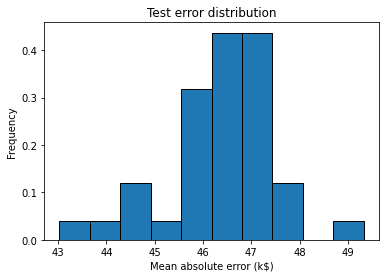

In [22]:
# plot results
cv_results["test_error"].plot.hist(bins=10, edgecolor="black", density=True)
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Test error distribution")

In [23]:
print(f"The mean cross-validated testing error is: "
      f"{cv_results['test_error'].mean():.2f} +/- {cv_results['test_error'].std():.2f} k$")

The mean cross-validated testing error is: 46.36 +/- 1.17 k$


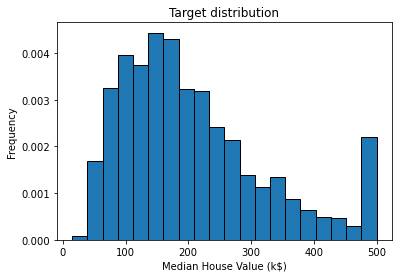

In [24]:
# examine distribution of the target variable
target.plot.hist(bins=20, edgecolor="black", density=True)
plt.xlabel("Median House Value (k$)")
_ = plt.title("Target distribution")

In [25]:
print(f"The standard deviation of the target is: {target.std():.2f} k$")

The standard deviation of the target is: 115.40 k$


On average our model makes an error around 47 kUSD. With this information and looking at the target distribution, such an error might be acceptable when predicting houses with a 500 kUSD. However, it would be an issue with a house with a value of 50 k$. Thus, this indicates that our metric (Mean Absolute Error) is not ideal.

We might instead choose a metric __relative to the target value__ to predict: the mean absolute percentage error would have been a much better choice.

But in all cases, an error of 47 k$ might be too large to automatically use our model to tag house values without expert supervision.

### (iii) cross_val_score

During cross-validation, many models are trained and evaluated. Indeed, the number of elements in each array of the output of `cross_validate` is a result from one of these `fit/score` procedures. To make it explicit, it is possible to retrieve these fitted models for each of the splits/folds by passing the option `return_estimator=True` in `cross_validate`.

In [28]:
cv_results = cross_validate(regressor, data, target, return_estimator=True, return_train_score=True)
cv_results

{'fit_time': array([0.15819931, 0.14533734, 0.17288947, 0.17956543, 0.18771195]),
 'score_time': array([0.        , 0.00208163, 0.0040009 , 0.        , 0.00300288]),
 'estimator': [DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0)],
 'test_score': array([0.26291527, 0.41947109, 0.44492564, 0.23357874, 0.40788361]),
 'train_score': array([1., 1., 1., 1., 1.])}

Having access to these regressors (the internal estimators) is handy because it allows to inspect the internal fitted parameters of these regressors.

In the case where you __only__ are interested in the __test score__, scikit-learn provide a `cross_val_score` function. It is __identical to calling the cross_validate function__ and to select the test_score only.

In [27]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(regressor, data, target)
scores

array([0.26291527, 0.41947109, 0.44492564, 0.23357874, 0.40788361])

## Other Strategies

### (i) Stratification

In [29]:
from sklearn.datasets import load_iris

data, target = load_iris(as_frame=True, return_X_y=True)

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold

model = make_pipeline(StandardScaler(), LogisticRegression())

# define the set with 9 samples
data_random = np.random.randn(9, 1)
cv = KFold(n_splits=3)
for train_index, test_index in cv.split(data_random):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [3 4 5 6 7 8] TEST: [0 1 2]
TRAIN: [0 1 2 6 7 8] TEST: [3 4 5]
TRAIN: [0 1 2 3 4 5] TEST: [6 7 8]


By defining three splits, we will use three samples for testing and six for training each time. __KFold does not shuffle by default__. It means that it will select the three first samples for the testing set at the first split, then the three next three samples for the second split, and the three next for the last split. In the end, __all sample__ have been used in testing __at least once__ among the different splits.

In [34]:
# check generalisation performance
cv = KFold(n_splits=3)
results = cross_validate(model, data, target, cv=cv)
test_score = results["test_score"]
print(f"The average accuracy is "
      f"{test_score.mean():.3f} +/- {test_score.std():.3f}")

The average accuracy is 0.000 +/- 0.000


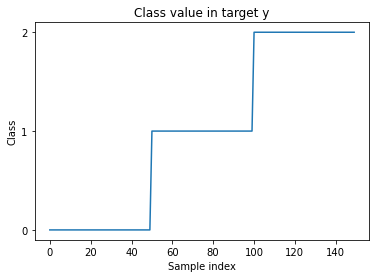

In [35]:
target.plot()
plt.xlabel("Sample index")
plt.ylabel("Class")
plt.yticks(target.unique())
_ = plt.title("Class value in target y")

We see that the target vector target is __ordered__. It will have some unexpected consequences when using the KFold cross-validation. To illustrate the consequences, we will show the class count in each fold of the cross-validation in the train and test set.

In [36]:
n_splits = 3
cv = KFold(n_splits=n_splits)

train_cv_counts = []
test_cv_counts = []
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(data, target)):
    target_train, target_test = target.iloc[train_idx], target.iloc[test_idx]

    train_cv_counts.append(target_train.value_counts())
    test_cv_counts.append(target_test.value_counts())

In [37]:
train_cv_counts = pd.concat(train_cv_counts, axis=1,
                            keys=[f"Fold #{idx}" for idx in range(n_splits)])
train_cv_counts.index.name = "Class label (Train Set)"
train_cv_counts

,Fold #0,Fold #1,Fold #2
Class label (Train Set),,,
0,NaN,50.0,50.0
1,50.0,NaN,50.0
2,50.0,50.0,NaN


In [38]:
test_cv_counts = pd.concat(test_cv_counts, axis=1,
                           keys=[f"Fold #{idx}" for idx in range(n_splits)])
test_cv_counts.index.name = "Class label (Test Set)"
test_cv_counts

,Fold #0,Fold #1,Fold #2
Class label (Test Set),,,
0,50.0,NaN,NaN
1,NaN,50.0,NaN
2,NaN,NaN,50.0


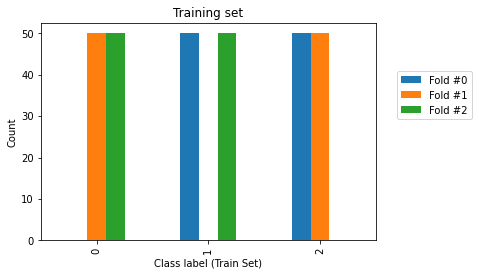

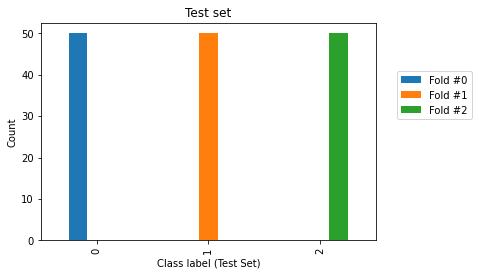

In [39]:
train_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Count")
_ = plt.title("Training set")

test_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Count")
_ = plt.title("Test set")

In [40]:
# solve order issue by shuffling the splits
cv = KFold(n_splits=3, shuffle=True, random_state=0)
results = cross_validate(model, data, target, cv=cv)
test_score = results["test_score"]
print(f"The average accuracy is "
      f"{test_score.mean():.3f} +/- {test_score.std():.3f}")

The average accuracy is 0.953 +/- 0.009


In [44]:
train_cv_counts = []
test_cv_counts = []
# iterate through the splits
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(data, target)):
    target_train, target_test = target.iloc[train_idx], target.iloc[test_idx]

    train_cv_counts.append(target_train.value_counts())
    test_cv_counts.append(target_test.value_counts())
# convert to df
train_cv_counts = pd.concat(train_cv_counts, axis=1,
                            keys=[f"Fold #{idx}" for idx in range(n_splits)])
test_cv_counts = pd.concat(test_cv_counts, axis=1,
                           keys=[f"Fold #{idx}" for idx in range(n_splits)])
train_cv_counts.index.name = "Class label"
test_cv_counts.index.name = "Class label"

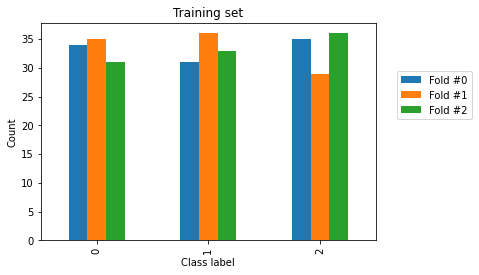

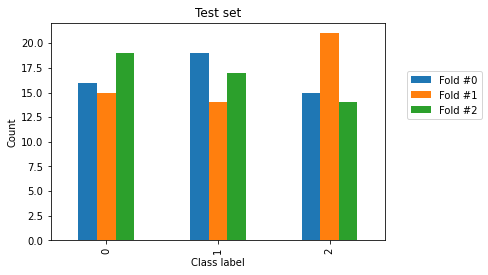

In [45]:
train_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Count")
_ = plt.title("Training set")

test_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Count")
_ = plt.title("Test set")

We see that __neither__ the training and testing sets have the __same class frequencies__ as our original dataset because the count for each class is varying a little.

However, one might want to split our data by __preserving the original class frequencies__: we want to __stratify__ our data by class. In scikit-learn, some cross-validation strategies implement the stratification; they contain Stratified in their names.

In [46]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=3)

In [47]:
results = cross_validate(model, data, target, cv=cv)
test_score = results["test_score"]
print(f"The average accuracy is "
      f"{test_score.mean():.3f} +/- {test_score.std():.3f}")

The average accuracy is 0.960 +/- 0.016


In [48]:
train_cv_counts = []
test_cv_counts = []
for fold_idx, (train_idx, test_idx) in enumerate(cv.split(data, target)):
    target_train, target_test = target.iloc[train_idx], target.iloc[test_idx]

    train_cv_counts.append(target_train.value_counts())
    test_cv_counts.append(target_test.value_counts())
train_cv_counts = pd.concat(train_cv_counts, axis=1,
                            keys=[f"Fold #{idx}" for idx in range(n_splits)])
test_cv_counts = pd.concat(test_cv_counts, axis=1,
                           keys=[f"Fold #{idx}" for idx in range(n_splits)])
train_cv_counts.index.name = "Class label"
test_cv_counts.index.name = "Class label"

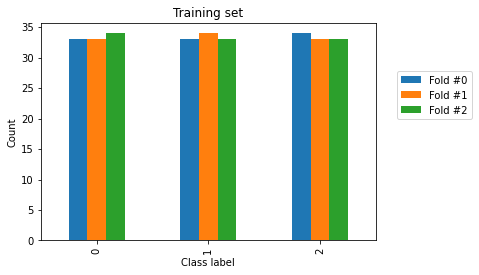

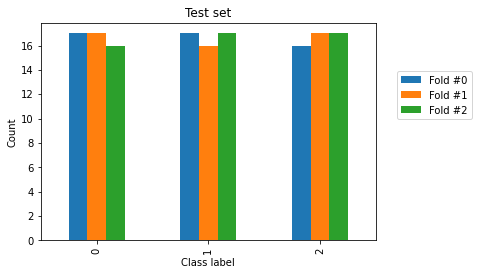

In [49]:
train_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Count")
_ = plt.title("Training set")

test_cv_counts.plot.bar()
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
plt.ylabel("Count")
_ = plt.title("Test set")

In this case, we observe that the class counts are very close both in the train set and the test set. The difference is due to the small number of samples in the iris dataset.

In conclusion, this is a __good practice to use stratification within the cross-validation framework when dealing with a classification problem__.

### (ii) Sample Grouping

In [50]:
from sklearn.datasets import load_digits

digits = load_digits()
data, target = digits.data, digits.target

In [51]:
model = make_pipeline(StandardScaler(), LogisticRegression())

In [52]:
cv = KFold(shuffle=False)
test_score_no_shuffling = cross_val_score(model, data, target, cv=cv,
                                          n_jobs=2)
print(f"The average accuracy without Shuffle is "
      f"{test_score_no_shuffling.mean():.3f} +/- "
      f"{test_score_no_shuffling.std():.3f}")

The average accuracy without Shuffle is 0.921 +/- 0.028


In [53]:
cv = KFold(shuffle=True)
test_score_with_shuffling = cross_val_score(model, data, target, cv=cv,
                                            n_jobs=2)
print(f"The average accuracy with Shuffle is "
      f"{test_score_with_shuffling.mean():.3f} +/- "
      f"{test_score_with_shuffling.std():.3f}")

The average accuracy with Shuffle is 0.973 +/- 0.009


In [54]:
all_scores = pd.DataFrame(
    [test_score_no_shuffling, test_score_with_shuffling],
    index=["KFold without shuffling", "KFold with shuffling"],
).T
all_scores

,KFold without shuffling,KFold with shuffling
0,0.922222,0.966667
1,0.883333,0.969444
2,0.941504,0.977716
3,0.961003,0.963788
4,0.896936,0.988858


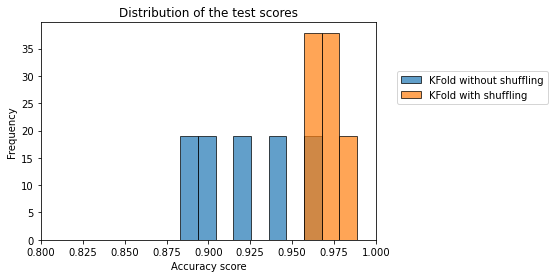

In [55]:
all_scores.plot.hist(bins=10, edgecolor="black", density=True, alpha=0.7)
plt.xlim([0.8, 1.0])
plt.xlabel("Accuracy score")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Distribution of the test scores")

The cross-validation testing error that uses the shuffling has less variance than the one that does not impose any shuffling. It means that __some specific fold leads to a low score__ in this case.

In [56]:
print(test_score_no_shuffling)

[0.92222222 0.88333333 0.94150418 0.96100279 0.89693593]


Thus, there is an underlying structure in the data that shuffling will break and get better results. To get a better understanding, we should read the documentation shipped with the dataset.

In [57]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

If we read carefully, 13 writers wrote the digits of our dataset, accounting for a total amount of 1797 samples. Thus, a writer wrote several times the same numbers. Let’s suppose that the writer samples are __grouped__. Subsequently, not shuffling the data will keep all writer samples together either in the training or the testing sets. __Mixing the data will break this structure__, and therefore digits written by the same writer will be available in __both__ the training and testing sets.

Besides, a writer will usually tend to write digits in the same manner. Thus, our model will learn to identify __a writer’s pattern__ for each digit instead of recognizing the digit itself.

We can solve this problem by ensuring that the data associated with a writer should either belong to the training or the testing set. Thus, we want to __group samples for each writer__.

Here, we will __manually__ define the group for the 13 writers.

In [58]:
from itertools import count

# defines the lower and upper bounds of sample indices
# for each writer
writer_boundaries = [0, 130, 256, 386, 516, 646, 776, 915, 1029,
                     1157, 1287, 1415, 1545, 1667, 1797]
groups = np.zeros_like(target)
lower_bounds = writer_boundaries[:-1]
upper_bounds = writer_boundaries[1:]

for group_id, lb, up in zip(count(), lower_bounds, upper_bounds):
    groups[lb:up] = group_id

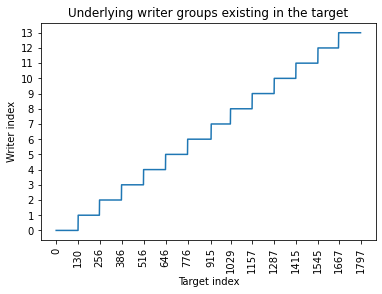

In [59]:
plt.plot(groups)
plt.yticks(np.unique(groups))
plt.xticks(writer_boundaries, rotation=90)
plt.xlabel("Target index")
plt.ylabel("Writer index")
_ = plt.title("Underlying writer groups existing in the target")

In [60]:
from sklearn.model_selection import GroupKFold

cv = GroupKFold()
test_score = cross_val_score(model, data, target, groups=groups, cv=cv,
                             n_jobs=2)
print(f"The average accuracy is "
      f"{test_score.mean():.3f} +/- "
      f"{test_score.std():.3f}")

The average accuracy is 0.919 +/- 0.015


We see that this strategy is less optimistic regarding the model generalization performance. However, this is the most reliable if our goal is to make handwritten digits recognition writers independent. Besides, we can as well see that the standard deviation was reduced.

In [61]:
all_scores = pd.DataFrame(
    [test_score_no_shuffling, test_score_with_shuffling, test_score],
    index=["KFold without shuffling", "KFold with shuffling",
           "KFold with groups"],
).T

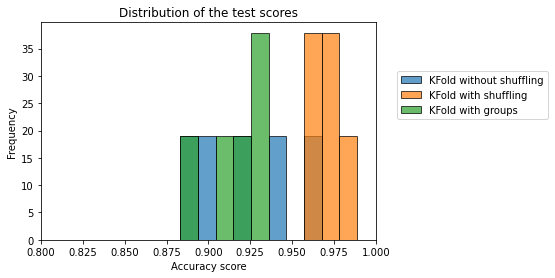

In [62]:
all_scores.plot.hist(bins=10, edgecolor="black", density=True, alpha=0.7)
plt.xlim([0.8, 1.0])
plt.xlabel("Accuracy score")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Distribution of the test scores")

As a conclusion, it is really important to take any sample grouping pattern into account when evaluating a model. Otherwise, the results obtained will be __over-optimistic__ in regards with reality.

### (iii) Non i.i.d. data (Non Independent and identically distributed)

In machine learning, it is quite common to assume that the data are i.i.d, meaning that the generative process does not have any memory of past samples to generate new samples.

This assumption is usually violated when dealing with __time series__. A sample depends on past information.

We will take an example to highlight such issues with non-i.i.d. data in the previous cross-validation strategies presented. We are going to load financial quotations from some energy companies.

In [63]:
symbols = {"TOT": "Total", "XOM": "Exxon", "CVX": "Chevron",
           "COP": "ConocoPhillips", "VLO": "Valero Energy"}
url = ("https://raw.githubusercontent.com/scikit-learn/examples-data/"
       "master/financial-data/{}.csv")

quotes = {}
for symbol in symbols:
    data = pd.read_csv(url.format(symbol), index_col=0, parse_dates=True)
    quotes[symbols[symbol]] = data["open"]
quotes = pd.DataFrame(quotes)

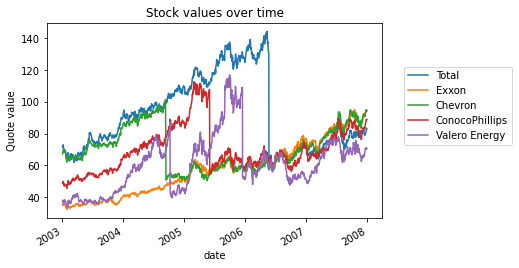

In [64]:
quotes.plot()
plt.ylabel("Quote value")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Stock values over time")

In [66]:
from sklearn.model_selection import train_test_split

# Want to try to predict Chevron from the rest of the data
data, target = quotes.drop(columns=["Chevron"]), quotes["Chevron"]

data_train, data_test, target_train, target_test = train_test_split(
    data, target, shuffle=True, random_state=0)

In [67]:
regressor = DecisionTreeRegressor()

cv = ShuffleSplit(random_state=0)

In [68]:
test_score = cross_val_score(regressor, data_train, target_train, cv=cv,
                             n_jobs=2)
print(f"The mean R2 is: "
      f"{test_score.mean():.2f} +/- {test_score.std():.2f}")

The mean R2 is: 0.95 +/- 0.07


Surprisingly, we get outstanding generalization performance. We will investigate and find the reason for such good results with a model that is expected to fail. Remember `ShuffleSplit` is an iterative cross-validation scheme that shuffles data and split. We will simplify this procedure with a single split and plot the prediction. We can use `train_test_split` for this purpose.

In [69]:
regressor.fit(data_train, target_train)
target_predicted = regressor.predict(data_test)
# Affect the index of `target_predicted` to ease the plotting
target_predicted = pd.Series(target_predicted, index=target_test.index)

In [70]:
from sklearn.metrics import r2_score

test_score = r2_score(target_test, target_predicted)
print(f"The R2 on this single split is: {test_score:.2f}")

The R2 on this single split is: 0.83


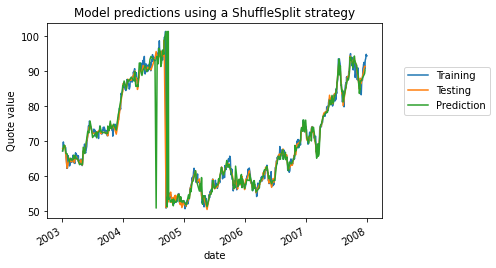

In [72]:
target_train.plot(label="Training")
target_test.plot(label="Testing")
target_predicted.plot(label="Prediction")

plt.ylabel("Quote value")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Model predictions using a ShuffleSplit strategy")

So in this context, it seems that the model predictions are following the testing. But we can also see that the testing samples are next to some training sample. And with these time-series, we see a relationship between a sample at the time `t` and a sample at `t+1`. In this case, __we are violating the i.i.d. assumption__. The insight to get is the following: 
- a model can output of its training set at the time `t` for a testing sample at the time `t+1`. 
- This prediction would be close to the true value even if our model __did not learn__ anything, but just __memorized__ the training dataset.

An easy way to verify this hypothesis is to __not shuffle__ the data when doing the split. In this case, we will use the first 75% of the data to train and the remaining data to test.

In [73]:
data_train, data_test, target_train, target_test = train_test_split(
    data, target, shuffle=False, random_state=0,
)
regressor.fit(data_train, target_train)
target_predicted = regressor.predict(data_test)
target_predicted = pd.Series(target_predicted, index=target_test.index)

In [74]:
test_score = r2_score(target_test, target_predicted)
print(f"The R2 on this single split is: {test_score:.2f}")

The R2 on this single split is: -2.05


In this case, we see that our model is not magical anymore. Indeed, it performs worse than just predicting the mean of the target. We can visually check what we are predicting.

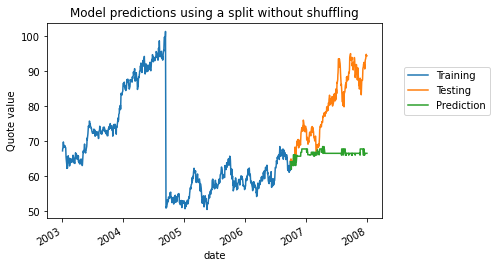

In [75]:
target_train.plot(label="Training")
target_test.plot(label="Testing")
target_predicted.plot(label="Prediction")

plt.ylabel("Quote value")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Model predictions using a split without shuffling")

One solution would be to group the samples into time blocks, e.g. by quarter, and predict each group’s information by using information from the other groups. We can use the `LeaveOneGroupOut` cross-validation for this purpose.

In [76]:
from sklearn.model_selection import LeaveOneGroupOut

# group by Quarter
groups = quotes.index.to_period("Q")
cv = LeaveOneGroupOut()
test_score = cross_val_score(regressor, data, target,
                             cv=cv, groups=groups, n_jobs=2)
print(f"The mean R2 is: "
      f"{test_score.mean():.2f} +/- {test_score.std():.2f}")

The mean R2 is: -0.77 +/- 1.65


In this case, we see that we cannot make good predictions, which is less surprising than our original results.

Another thing to consider is the actual application of our solution. If our model is aimed at forecasting (i.e., predicting future data from past data), we should not use training data that are ulterior to the testing data. In this case, we can use the `TimeSeriesSplit` cross-validation to enforce this behaviour.

In [77]:
from sklearn.model_selection import TimeSeriesSplit

# using the Quarterly grouping still
cv = TimeSeriesSplit(n_splits=groups.nunique())
test_score = cross_val_score(regressor, data, target,
                             cv=cv, groups=groups, n_jobs=2)
print(f"The mean R2 is: "
      f"{test_score.mean():.2f} +/- {test_score.std():.2f}")

The mean R2 is: -1.32 +/- 1.90


In conclusion, it is really important to not use an out of the shelves cross-validation strategy which do not respect some assumptions such as having i.i.d data. It might lead to absurd results which could make think that a predictive model might work.

## Nested Cross Validation

### (i) Unnested (Hyperparameter only)

In [79]:
# load data and split into features + target
target_name = "class"
adult_census = pd.read_csv("datasets/adult-census.csv")
target = adult_census[target_name]
data = adult_census.drop(columns=[target_name, "education-num"])

In [82]:
from sklearn import set_config

# To get a diagram visualization of the pipeline
set_config(display="diagram")

In [85]:
# set up preprocessor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

categorical_preprocessor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
preprocessor = ColumnTransformer(
    [
        ('cat_preprocessor', categorical_preprocessor, categorical_columns),
    ],
    remainder='passthrough',
    sparse_threshold=0,
)

In [86]:
# create model
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("preprocessor", preprocessor),
    (
        "classifier",
        HistGradientBoostingClassifier(
            random_state=42, max_leaf_nodes=4
        )
    ),
])
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                random_state=42))])

In [87]:
# use GridSearch to tune hyperparameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__learning_rate': (0.05, 0.5),
    'classifier__max_leaf_nodes': (10, 30),
}
model_grid_search = GridSearchCV(
    model, param_grid=param_grid, n_jobs=2, cv=2
)
model_grid_search.fit(data, target)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('cat_preprocessor',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['workclass',
                                                                          'education',
                                                                          'marital-status',
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'sex',
                                                                          'native-country'])])),
                                       ('classifier',
                                        HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                                       random_state=42))]),
             n_jobs=2,
             param_grid={'classifier__learning_rate': (0.05, 0.5),
                         'classifier__max_leaf_nodes': (10, 30)})

As previously seen, when calling the `fit` method, the model embedded in the grid-search is trained with every possible combination of parameters resulting from the parameter grid. The best combination is selected by __keeping the combination leading to the best mean cross-validated score__.

In [88]:
cv_results = pd.DataFrame(model_grid_search.cv_results_)
cv_results[[
    "param_classifier__learning_rate",
    "param_classifier__max_leaf_nodes",
    "mean_test_score",
    "std_test_score",
    "rank_test_score"
]]

,param_classifier__learning_rate,param_classifier__max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
0,0.05,10,0.864195,0.000061,4
1,0.05,30,0.870910,0.000061,1
2,0.5,10,0.869457,0.000819,2
3,0.5,30,0.866365,0.001822,3


The issue here is the evaluation of the __generalization performance__. Indeed, the mean and standard deviation of the scores computed by the cross-validation in the grid-search are potentially __not good estimates of the generalization performance__ we would obtain by refitting a model with the best combination of hyper-parameter values on the full dataset. Note that scikit-learn automatically performs this refit by default when calling `model_grid_search.fit`. This refitted model is trained with more data than the different models trained internally during the cross-validation of the grid-search.

We therefore used knowledge from the full dataset to __both__ decide our model’s hyper-parameters and to train the refitted model.

Because of the above, one must keep an __external, held-out test set__ for the __final evaluation__ the refitted model. We highlight here the process using a single train-test split.

In [90]:
data_train, data_test, target_train, target_test = train_test_split(
    data, target, test_size=0.2, random_state=42
)

model_grid_search.fit(data_train, target_train)
accuracy = model_grid_search.score(data_test, target_test)
print(f"Accuracy on test set: {accuracy:.3f}")

Accuracy on test set: 0.877


The score measure on the final test set is almost with the range of the internal CV score for the best hyper-parameter combination. This is reassuring as it means that the tuning procedure did not cause significant overfitting in itself (other-wise the final test score would have been lower than the internal CV scores). That is expected because our grid search explored very few hyper-parameter combinations for the sake of speed. The test score of the final model is actually a bit higher that what we could have expected from the internal cross-validation. This is also expected because the __refitted model is trained on a larger dataset__ than the models evaluated in the internal CV loop of the grid-search procedure. This is often the case that models trained on a larger number of samples tend to generalize better.

In the code above, the __selection of the best hyperparameters was done only on the train set__ from the initial train-test split. Then, we evaluated the generalization performance of our tuned model on the __left out test set__. This can be shown schematically as follows:

<img src="diagrams/HyperparamCV.jpg" width=600/>

This figure shows the particular case of `K-fold` cross-validation strategy using n_splits=5 to further split the train set coming from a train-test split. For each cross-validation split, the procedure trains a model on all the red samples, evaluates the score of a given set of hyperparameters on the green samples. The best hyper-parameters are selected based on those intermediate scores.

The a final model tuned with those hyper-parameters is fitted on the concatenation of the red and green samples and evaluated on the blue samples.

The green samples are sometimes called __validation sets__ to differentiate them from the final test set in blue.

However, this evaluation only provides us a single point estimate of the generalization performance. Therefore, we should instead use an additional cross-validation for this evaluation.

### (ii) Nested

__Nested cross-validation__ uses an __inner__ cross-validation for the selection of the hyperparameters and an __outer__ cross-validation for the evaluation of generalization performance of the refitted tuned model.

In practice, we only need to embed the grid-search in the function cross-validate to perform such evaluation.

In [91]:
cv_results = cross_validate(
    model_grid_search, data, target, cv=5, n_jobs=2, return_estimator=True
)

In [92]:
cv_results = pd.DataFrame(cv_results)
cv_test_scores = cv_results['test_score']
print(
    "Generalization score with hyperparameters tuning:\n"
    f"{cv_test_scores.mean():.3f} +/- {cv_test_scores.std():.3f}"
)

Generalization score with hyperparameters tuning:
0.871 +/- 0.003


This result is compatible with the test score measured with the string outer train-test split.

However, in this case, we can capture the __variability__ of our estimate of the generalization performance thanks to the measure of the __standard-deviation__ of the scores measured in the __outer__ cross-validation.

<img src="diagrams/NestedCV.jpg" width=600/>

This figure illustrates the nested cross-validation strategy using `cv_inner = KFold(n_splits=4)` and `cv_outer = KFold(n_splits=5)`.

For each __inner__ cross-validation split (indexed on the left-hand side), the procedure trains a model on all the red samples and evaluate the quality of the hyperparameters on the green samples.

For each __outer__ cross-validation split (indexed on the right-hand side), the best hyper-parameters are selected based on the validation scores (computed on the green samples) and a model is refitted on the __concatenation__ of the red and green samples for that outer CV iteration.

The generalization performance of the 5 refitted models from the outer CV loop are then evaluated on the blue samples to get the final scores.

In addition, passing the parameter `return_estimator=True`, we can check the value of the best hyperparameters obtained for each fold of the outer cross-validation.

In [93]:
for cv_fold, estimator_in_fold in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for fold #{cv_fold + 1}:\n"
        f"{estimator_in_fold.best_params_}"
    )

Best hyperparameters for fold #1:
{'classifier__learning_rate': 0.05, 'classifier__max_leaf_nodes': 30}
Best hyperparameters for fold #2:
{'classifier__learning_rate': 0.05, 'classifier__max_leaf_nodes': 30}
Best hyperparameters for fold #3:
{'classifier__learning_rate': 0.05, 'classifier__max_leaf_nodes': 30}
Best hyperparameters for fold #4:
{'classifier__learning_rate': 0.05, 'classifier__max_leaf_nodes': 30}
Best hyperparameters for fold #5:
{'classifier__learning_rate': 0.05, 'classifier__max_leaf_nodes': 30}


It is interesting to see whether the hyper-parameter tuning procedure always select similar values for the hyperparameters. If its the case, then all is fine. It means that we can deploy a model fit with those hyperparameters and expect that it will have an actual predictive performance close to what we measured in the outer cross-validation.

But it is also possible that some hyperparameters do not matter at all, and as a result in different tuning sessions give different results. In this case, any value will do. This can typically be confirmed by doing a parallel coordinate plot of the results of a large hyperparameter search as seen in the exercises.

From a __deployment__ point of view, one could also chose to deploy all the models found by the outer cross-validation loop and make them vote to get the final predictions. However this can cause operational problems because it uses more memory and makes computing prediction slower, resulting in a higher computational resource usage per prediction.

### (iii) Importance of Nested CV

When considering the test score of a model without nested CV we must be careful. The misinterpretation would be the following: since this mean score was computed using cross-validation test sets, we could use it to assess the generalization performance of the model trained with the best hyper-parameters.

However, we __used this score to pick-up the best model__. It means that we __used knowledge from the test sets__ (i.e. test scores) to select the hyper-parameter of the model itself.

Thus, this mean score is __not a fair estimate__ of our testing error. Indeed, it can be too __optimistic__, in particular when running a parameter search on a large grid with many hyper-parameters and many possible values per hyper-parameter. A way to avoid this pitfall is to use a __nested__ cross-validation.

In the following, we will use an inner cross-validation to only optimize the hyperparameters. We will also embed this tuning procedure within an outer cross-validation, which is dedicated to estimate the testing error of our tuned model.

In this case, our inner cross-validation always gets the __training set__ of the outer cross-validation, making it possible to always compute the final testing scores on __completely independent sets of samples__.

In [94]:
from sklearn.datasets import load_breast_cancer

data, target = load_breast_cancer(return_X_y=True)

In [97]:
from sklearn.svm import SVC

param_grid = {"C": [0.1, 1, 10], "gamma": [.01, .1]}
model_to_tune = SVC()

test_score_not_nested = []
test_score_nested = []

N_TRIALS = 20
for i in range(N_TRIALS):
    # For each trial, we use cross-validation splits on independently
    # randomly shuffled data by passing distinct values to the random_state
    # parameter.
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    model = GridSearchCV(estimator=model_to_tune, param_grid=param_grid,
                         cv=inner_cv, n_jobs=2)
    model.fit(data, target)
    test_score_not_nested.append(model.best_score_)

    # Nested CV with parameter optimization
    test_score = cross_val_score(model, data, target, cv=outer_cv, n_jobs=2)
    test_score_nested.append(test_score.mean())

In [98]:
all_scores = {
    "Not nested CV": test_score_not_nested,
    "Nested CV": test_score_nested,
}
all_scores = pd.DataFrame(all_scores)

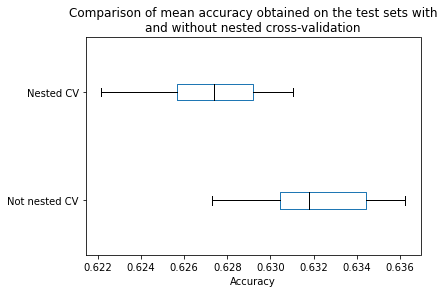

In [99]:
color = {"whiskers": "black", "medians": "black", "caps": "black"}
all_scores.plot.box(color=color, vert=False)
plt.xlabel("Accuracy")
_ = plt.title("Comparison of mean accuracy obtained on the test sets with\n"
              "and without nested cross-validation")

We observe that the generalization performance estimated without using nested CV is higher than what we obtain with nested CV.
- The reason is that the tuning procedure itself selects the model with the highest inner CV score. 

If there are many hyper-parameter combinations and if the inner CV scores have comparatively large standard deviations, taking the maximum value can lure the naive data scientist into __over-estimating the true generalization performance__ of the result of the full learning procedure. By using an outer cross-validation procedure one gets a more trustworthy estimate of the generalization performance of the full learning procedure, including the effect of tuning the hyperparameters.

As a conclusion, when optimizing parts of the machine learning pipeline (e.g. hyperparameter, transform, etc.), one __needs to use nested cross-validation to evaluate the generalization performance__ of the predictive model. Otherwise, the results obtained without nested cross-validation are often overly optimistic.

## Classification Metrics

## Regression Metrics